In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)

import statsmodels.tsa.stattools as sss
from tqdm.notebook import tqdm

import sys
sys.path.append('../')
from general_purpose import uplotlib as uplt

In [2]:
ctrl = np.load('__test__/amoc_max_f8_2_yearly.npy')
ctrl[0] -= ctrl[0,0] # set initial time to 0
ctrl.shape

(2, 20000)

In [3]:
ctrl5_0 = np.convolve(ctrl[0],np.ones(5)/5, mode='valid')[::5]
ctrl5_1 = np.convolve(ctrl[1],np.ones(5)/5, mode='valid')[::5]

ctrl5 = np.stack([ctrl5_0,ctrl5_1])
ctrl5.shape

(2, 4000)

In [4]:
rr = []
for i in range(50):
    rr.append(np.load(f'__test__/rr_minimal/e{i+1:02d}-traj.npy'))
rr = np.concatenate(rr).T
rr[1] *= -1
rr[0] -= rr[0,0]
rr.shape

(2, 1000)

## Timeseries

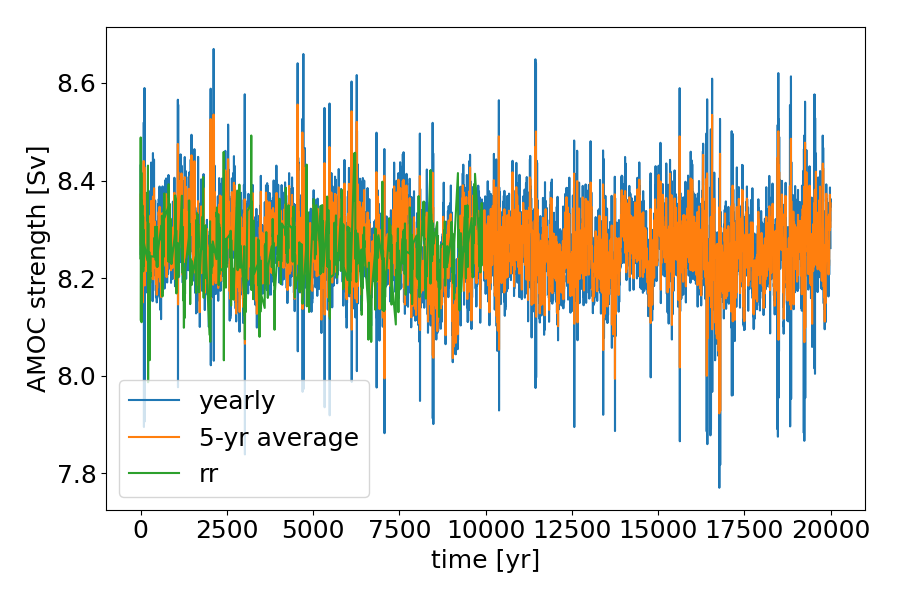

In [5]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

plt.plot(ctrl[0], ctrl[1], label='yearly')
plt.plot(ctrl5[0], ctrl5[1], label='5-yr average')

plt.plot(rr[0], rr[1], label='rr')

plt.xlabel('time [yr]')
plt.ylabel('AMOC strength [Sv]')

plt.legend()

fig.tight_layout()

## Histogram

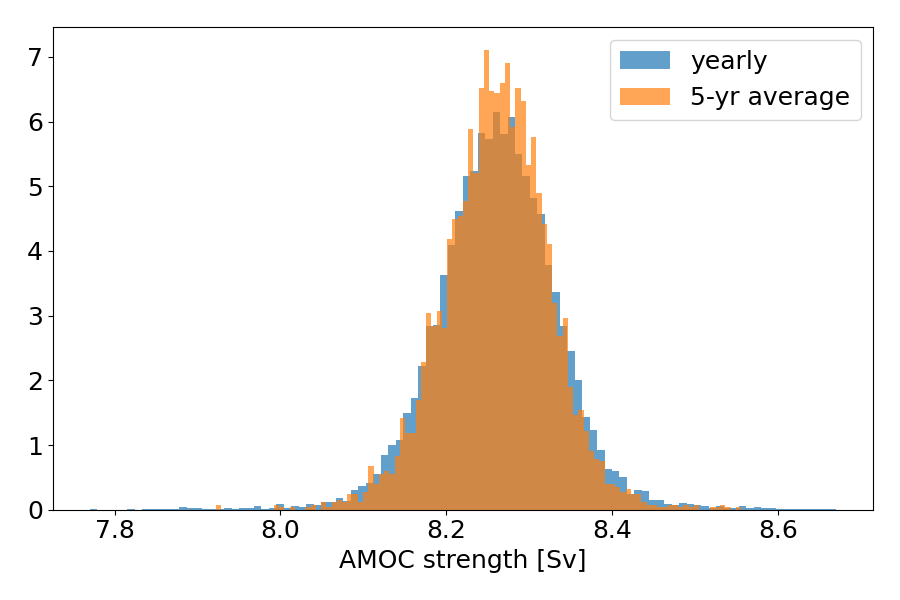

In [6]:
bins = 100

plt.close(2)
fig, ax = plt.subplots(num=2, figsize=(9,6))

plt.hist(ctrl[1], density=True, bins=bins, alpha=0.7, label='yearly')
plt.hist(ctrl5[1], density=True, bins=bins, alpha=0.7, label='5-yr average')

plt.xlabel('AMOC strength [Sv]')

plt.legend()

fig.tight_layout()

## Autocorrelation

In [7]:
lags = 200
acf = sss.acf(ctrl[1], nlags=lags-1)
acf5 = sss.acf(ctrl5[1], nlags=lags//5-1)

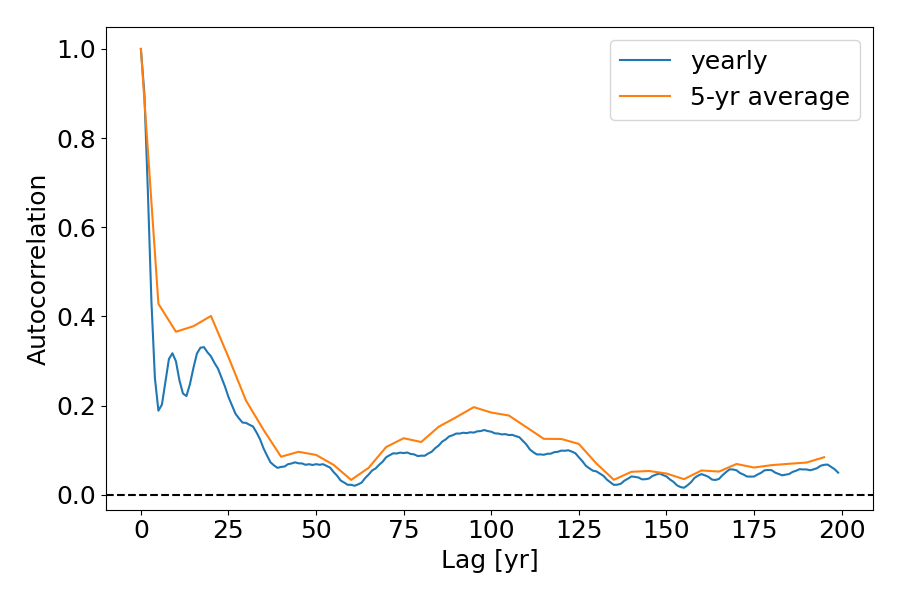

In [8]:
plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(9,6))

plt.plot(np.arange(lags), acf, label='yearly')
plt.plot(np.arange(lags)[::5], acf5, label='5-yr average')

plt.axhline(0, linestyle='dashed', color='black')

plt.xlabel('Lag [yr]')
plt.ylabel('Autocorrelation')
plt.legend()

fig.tight_layout()

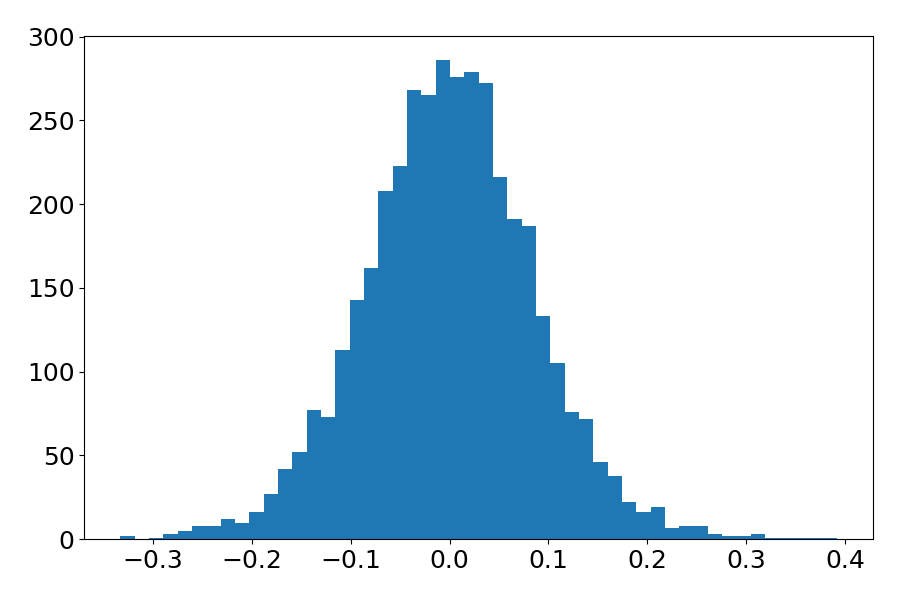

In [14]:
lag = 50
plt.close(4)
fig,ax = plt.subplots(num=4, figsize=(9,6))

diffs = ctrl5[1,lag//5:] - ctrl5[1,:-lag//5]

plt.hist(diffs, bins=50)

fig.tight_layout()

In [10]:
np.std(diffs)

0.08673818795030139

## Try to compute a plausible value of k

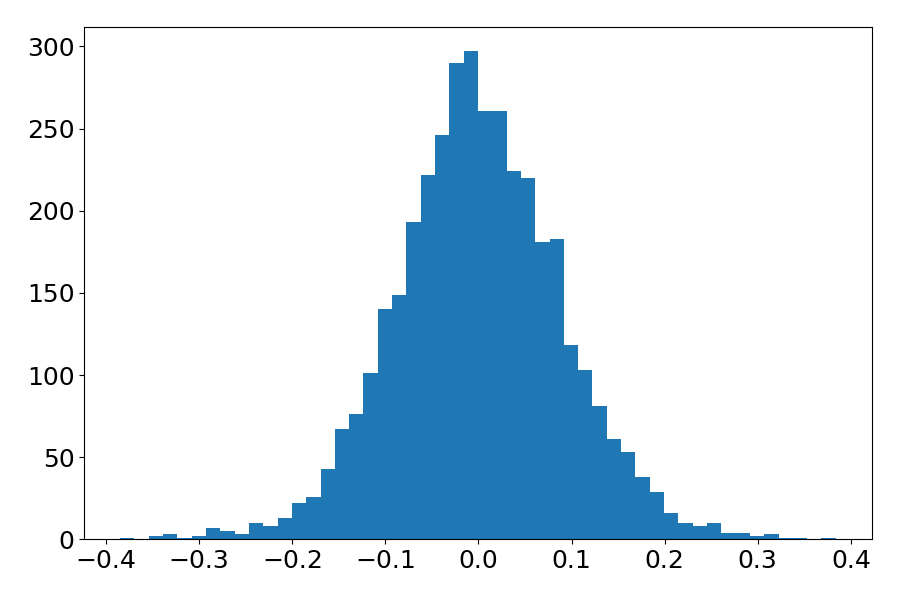

In [15]:
lag = 1000

diffs = ctrl5[1,lag//5:] - ctrl5[1,:-lag//5]

plt.close(5)
fig, ax = plt.subplots(num=5, figsize=(9,6))

plt.hist(diffs, bins=50)

fig.tight_layout()

In [16]:
coeff = 1/np.std(diffs)
coeff

11.10138299964422

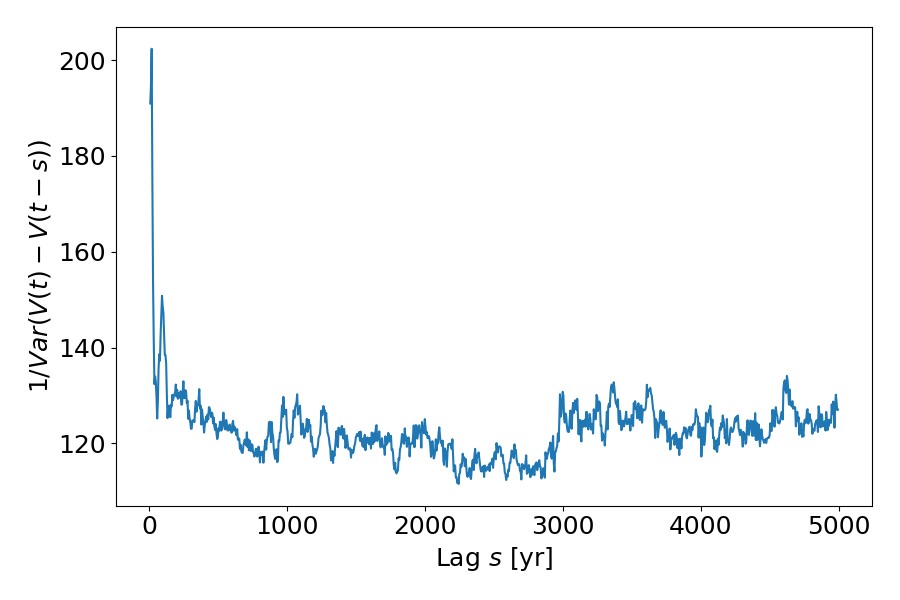

In [23]:
# coefficient for choosing k based on the extremity of the level:
# k = 1/std(V(t) - V(t-s)) * a

lags = np.arange(10, 5000, 5)
coeffs = []
for lag in lags:
    diffs = ctrl5[1,lag//5:] - ctrl5[1,:-lag//5]
    coeffs.append(1/np.std(diffs)**2)
coeffs = np.array(coeffs)

plt.close(6)
fig, ax = plt.subplots(num=6, figsize=(9,6))

plt.plot(lags, coeffs)

plt.xlabel('Lag $s$ [yr]')
plt.ylabel(r'$1/Var(V(t) - V(t-s))$')

fig.tight_layout()

## Kill ratio vs k

In [11]:
def softmax(x, axis=None):
    x = np.exp(x)
    return x/np.sum(x, axis=axis)

def kill_ratio(ks=1, sigma=1, N=50, samples=500):
    kill_ratios = []
    for i in range(samples):
        x = np.random.normal(0,sigma, size=N)
        y = N*softmax(ks*x)
        kill_ratios.append(np.sum(1 - y[y < 1])/N)
    return uplt.avg(kill_ratios).item()

In [12]:
sigma = 1
ks = np.arange(0, 20, 0.2)
N = 100
samples = 500

krs = []
for k in tqdm(ks):
    krs.append(kill_ratio(sigma*k, N=N, samples=samples))
krs = np.array(krs)

  0%|          | 0/100 [00:00<?, ?it/s]

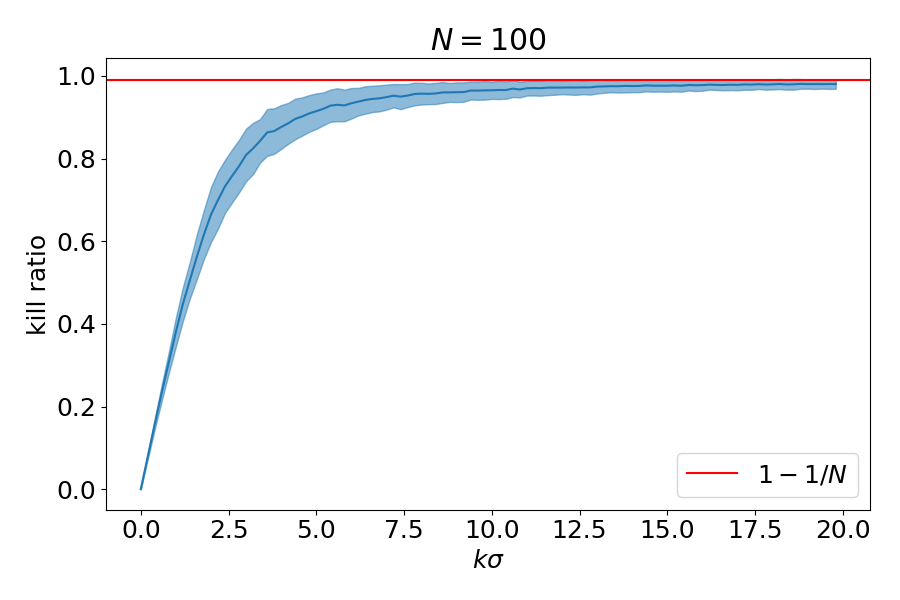

In [13]:
plt.close(7)
fig,ax = plt.subplots(num=7, figsize=(9,6))
uplt.errorband(ks*sigma, krs)

plt.axhline(1 - 1/N, color='red', label=r'$1 - 1/N$')

plt.xlabel(r'$k\sigma$')
plt.ylabel('kill ratio')

plt.title(fr'${N = }$')
plt.legend()

fig.tight_layout()

In [ ]:
kill_ratio(ks=1.8)

In [ ]:
1.8/np.std(diffs)

In [ ]:
kill_ratio(6.9*np.std(diffs))